# Finetuning moondream

This notebook demonstrates how to fine-tune moondream to improve performance on a downstream task.

The first step is to construct a dataset split into `train`, `validation`, and `test` sets. This is
not strictly necessary and can be skipped if you're fine-tuning on a very small amount of data. We
will train the model on the `train` set, use the `validation` set to tune hyperparameters and prevent
overfitting, and finally evaluate the model on the `test` set.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%pip install torch transformers timm einops datasets bitsandbytes accelerate flash_attn Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2

In [ ]:
from torch.utils.data import Dataset
from datasets import load_dataset
from datasets import DatasetDict
from PIL import Image

dataset = load_dataset("imagefolder", data_dir="/content/gdrive/MyDrive/tanks", split="train")

# def convert_to_rgb(examples):
#     examples["image"] = [Image.fromarray(image.convert("RGB")) for image in examples["image"]]
#     return examples


train_testvalid = dataset.train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
datasets = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(dataset)


Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'vehicle_type', 'pov'],
    num_rows: 99
})


In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'vehicle_type', 'pov'],
        num_rows: 79
    })
    test: Dataset({
        features: ['image', 'vehicle_type', 'pov'],
        num_rows: 10
    })
    valid: Dataset({
        features: ['image', 'vehicle_type', 'pov'],
        num_rows: 10
    })
})

Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [ ]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-04-02"

# attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

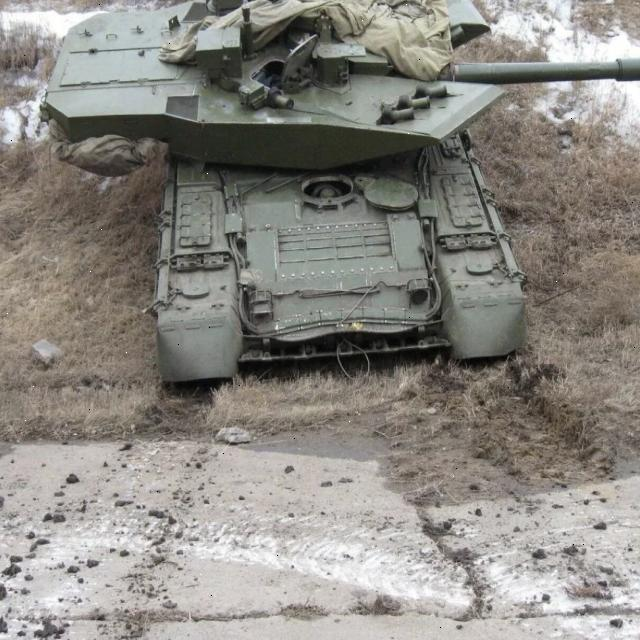

In [ ]:
from IPython.display import display

# sample = datasets['train'][0]
sample = datasets['train'][0]
# sample = datasets['train'][0]
display(sample['image'])


In [ ]:
print(sample["image"])

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39DD211E70>


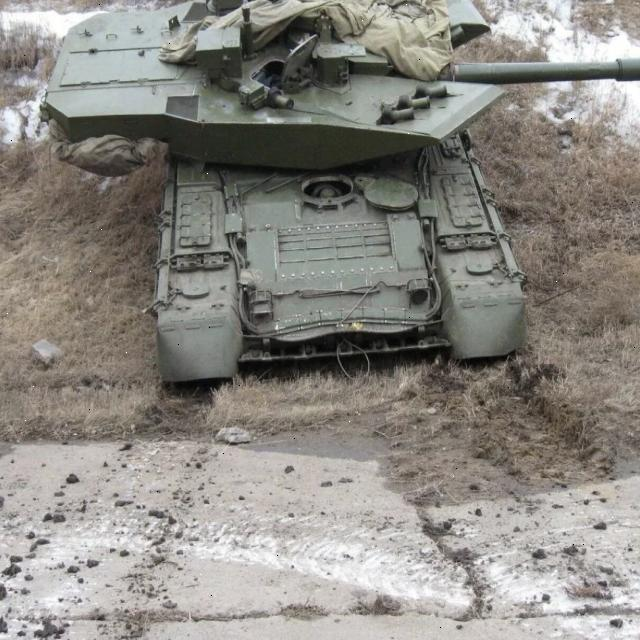

The image features a military vehicle, specifically a tank, sitting on the ground.


In [ ]:
from IPython.display import display

# sample = datasets['train'][0]
sample = datasets['train'][0]
# sample = datasets['train'][0]
display(sample['image'])

# for qa in sample['qa']:
#     print('Question:', qa['question'])
#     print('Ground Truth:', qa['answer'])
#     print('Moondream:', moondream.answer_question(
#         moondream.encode_image(sample['image']),
#         qa['question'],
#         tokenizer=tokenizer,
#     ))


print(moondream.answer_question(
        moondream.encode_image(sample['image']),
        "What kind of vehicle is in this image?",
        tokenizer=tokenizer,
        ))

Let's start setting up hyperparameters for finetuning.

In [ ]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 2

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 8 currently uses around
# 15 GB of GPU memory during fine-tuning.
BATCH_SIZE = 2

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 1

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 3e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

ANSWER_EOS = "<|endoftext|>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    print(images)
    images = torch.stack(moondream.vision_encoder.preprocess(images))
    images = rearrange(images,
                       "b c (h p1) (w p2) -> b (h w) (c p1 p2)",
                       p1=14, p2=14)

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        question = "What track do you see, and what kind of military vehicle is in this image?"
        answer = sample["vehicle_type"] + " " + sample["pov"]
        print(question, answer)

        q_t = tokenizer(
            f"\n\nQuestion: {question}\n\nAnswer:",
            add_special_tokens=False
        ).input_ids
        toks.extend(q_t)
        labs.extend([-100] * len(q_t))

        a_t = tokenizer(
            f" {answer}{ANSWER_EOS}",
            add_special_tokens=False
        ).input_ids
        toks.extend(a_t)
        labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images.to(dtype=DTYPE),
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    images = images.to(DEVICE)
    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder.encoder(images)
        img_embs = moondream.vision_encoder.projection(img_embs)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "val": DataLoader(
        datasets["valid"],
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
    ),
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if i % 100 == 0 and USE_WANDB:
            # Calculate validation loss
            val_loss = 0
            for val_batch in tqdm(dataloaders["val"], desc="Validation"):
                with torch.no_grad():
                    val_loss += compute_loss(val_batch).item()
            val_loss /= len(dataloaders["val"])

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            } | ({"loss/val": val_loss} if i % 100 == 0 else {}))

if USE_WANDB:
    wandb.finish()

Epoch 1/2:   0%|          | 0/40 [00:00<?, ?it/s]WARNING:transformers_modules.vikhyatk.moondream2.9ba2958f5a886de83fa18a235d651295a05b4d13.modeling_phi:`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1506x801 at 0x7B39D0607AC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607BE0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:   2%|▎         | 1/40 [00:01<01:10,  1.80s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1045x561 at 0x7B39D0607850>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607DF0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? IFV land


Epoch 1/2:   5%|▌         | 2/40 [00:03<01:04,  1.71s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1493x777 at 0x7B39D0607BB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1580x865 at 0x7B39D0607430>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:   8%|▊         | 3/40 [00:05<01:01,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1467x771 at 0x7B39D0607A00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607E50>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  10%|█         | 4/40 [00:06<00:59,  1.65s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607880>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1547x793 at 0x7B39D0607670>]
What track do you see, and what kind of military vehicle is in this image? IFV air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  12%|█▎        | 5/40 [00:08<00:57,  1.65s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1460x772 at 0x7B39D0607CD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607FD0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  15%|█▌        | 6/40 [00:09<00:55,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607D60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607910>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  18%|█▊        | 7/40 [00:11<00:53,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1093x705 at 0x7B39D0607D00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06800A0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  20%|██        | 8/40 [00:13<00:52,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1489x773 at 0x7B39D06076A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06800D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  22%|██▎       | 9/40 [00:14<00:50,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1918x1006 at 0x7B39D06840A0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  25%|██▌       | 10/40 [00:16<00:48,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1479x758 at 0x7B39D0607FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06880D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  28%|██▊       | 11/40 [00:18<00:47,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x772 at 0x7B39D0607DC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1538x777 at 0x7B39D068C100>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  30%|███       | 12/40 [00:19<00:45,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D068C190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D068C0D0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  32%|███▎      | 13/40 [00:21<00:44,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1518x825 at 0x7B39D068C040>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D068C250>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  35%|███▌      | 14/40 [00:23<00:42,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1045x801 at 0x7B39D0607FA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D068C0D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  38%|███▊      | 15/40 [00:24<00:40,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607940>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1896x1041 at 0x7B39D06902B0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  40%|████      | 16/40 [00:26<00:39,  1.63s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0694220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06942E0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? IFV land


Epoch 1/2:  42%|████▎     | 17/40 [00:27<00:38,  1.66s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0690220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06902E0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  45%|████▌     | 18/40 [00:29<00:36,  1.65s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06903A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06902B0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  48%|████▊     | 19/40 [00:31<00:34,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1206x729 at 0x7B39D06076A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0690340>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  50%|█████     | 20/40 [00:32<00:32,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=686x632 at 0x7B39D0607D00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1173x707 at 0x7B39D06903D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  52%|█████▎    | 21/40 [00:34<00:31,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1431x759 at 0x7B39D0607910>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06983D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  55%|█████▌    | 22/40 [00:36<00:29,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1532x831 at 0x7B39D0607430>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698400>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  57%|█████▊    | 23/40 [00:37<00:27,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607DC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06983A0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  60%|██████    | 24/40 [00:39<00:26,  1.64s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06981C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1470x797 at 0x7B39D0698520>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  62%|██████▎   | 25/40 [00:41<00:24,  1.65s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=896x1074 at 0x7B39D06980D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698370>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  65%|██████▌   | 26/40 [00:42<00:23,  1.65s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1529x817 at 0x7B39D0607C70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06985E0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  68%|██████▊   | 27/40 [00:44<00:21,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1511x795 at 0x7B39D0698400>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698310>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  70%|███████   | 28/40 [00:46<00:20,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06984F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06981F0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  72%|███████▎  | 29/40 [00:48<00:18,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1541x788 at 0x7B39D06980A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06983A0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  75%|███████▌  | 30/40 [00:49<00:16,  1.70s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1515x783 at 0x7B39D0607DC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1328x782 at 0x7B39D0698430>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  78%|███████▊  | 31/40 [00:51<00:15,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1432x811 at 0x7B39D6B54CA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1329x759 at 0x7B39D0698190>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  80%|████████  | 32/40 [00:52<00:13,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1072x846 at 0x7B39D0698280>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06982B0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  82%|████████▎ | 33/40 [00:54<00:11,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698070>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698580>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  85%|████████▌ | 34/40 [00:56<00:10,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698700>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06980D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 1/2:  88%|████████▊ | 35/40 [00:57<00:08,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06984F0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  90%|█████████ | 36/40 [00:59<00:06,  1.66s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D6B54CA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1358x763 at 0x7B39D0698790>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  92%|█████████▎| 37/40 [01:01<00:04,  1.66s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0607FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1532x783 at 0x7B39D0698160>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  95%|█████████▌| 38/40 [01:02<00:03,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B3A0A863760>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1503x735 at 0x7B39D06984C0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 1/2:  98%|█████████▊| 39/40 [01:04<00:01,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698190>]
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:   0%|          | 0/40 [00:00<?, ?it/s]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1072x846 at 0x7B39D06987C0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:   2%|▎         | 1/40 [00:01<01:05,  1.67s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698520>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1493x777 at 0x7B39D0698040>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:   5%|▌         | 2/40 [00:03<01:04,  1.70s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698730>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06987F0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:   8%|▊         | 3/40 [00:05<01:02,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698820>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x772 at 0x7B39D0698220>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  10%|█         | 4/40 [00:06<01:00,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698970>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698190>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  12%|█▎        | 5/40 [00:08<00:58,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1460x772 at 0x7B39D06981C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1511x795 at 0x7B39D0698460>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  15%|█▌        | 6/40 [00:10<00:57,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1093x705 at 0x7B39D0698880>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698940>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  18%|█▊        | 7/40 [00:11<00:55,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1467x771 at 0x7B39D0698400>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06981C0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  20%|██        | 8/40 [00:13<00:53,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1489x773 at 0x7B39D0698400>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=896x1074 at 0x7B39D06981C0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  22%|██▎       | 9/40 [00:15<00:52,  1.68s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698100>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698310>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  25%|██▌       | 10/40 [00:16<00:50,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1479x758 at 0x7B39D0698040>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698370>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  28%|██▊       | 11/40 [00:18<00:49,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698A00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1515x783 at 0x7B39D0698580>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  30%|███       | 12/40 [00:20<00:47,  1.70s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698A90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1547x793 at 0x7B39D0698100>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  32%|███▎      | 13/40 [00:21<00:45,  1.70s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698790>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06988E0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  35%|███▌      | 14/40 [00:23<00:44,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1431x759 at 0x7B39D0698310>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698B80>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  38%|███▊      | 15/40 [00:25<00:42,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1532x783 at 0x7B39D0698A90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698B20>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  40%|████      | 16/40 [00:27<00:40,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698880>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698B80>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  42%|████▎     | 17/40 [00:28<00:38,  1.69s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1518x825 at 0x7B39D0698220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698C10>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  45%|████▌     | 18/40 [00:30<00:37,  1.71s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1918x1006 at 0x7B39D06983A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1173x707 at 0x7B39D06986D0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  48%|████▊     | 19/40 [00:32<00:36,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06989D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06981C0>]
What track do you see, and what kind of military vehicle is in this image? IFV land
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  50%|█████     | 20/40 [00:33<00:34,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1506x801 at 0x7B39D0698BE0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06989A0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  52%|█████▎    | 21/40 [00:35<00:32,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1329x759 at 0x7B39D0698670>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698790>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  55%|█████▌    | 22/40 [00:37<00:30,  1.71s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698B20>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1045x801 at 0x7B39D0698970>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  57%|█████▊    | 23/40 [00:39<00:29,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698CA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698B50>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  60%|██████    | 24/40 [00:40<00:27,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1503x735 at 0x7B39D0698190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1580x865 at 0x7B39D0698310>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  62%|██████▎   | 25/40 [00:42<00:25,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698580>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698BE0>]
What track do you see, and what kind of military vehicle is in this image? IFV air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  65%|██████▌   | 26/40 [00:44<00:24,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1206x729 at 0x7B39D0698C70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1529x817 at 0x7B39D0698430>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  68%|██████▊   | 27/40 [00:46<00:22,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698DC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698970>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  70%|███████   | 28/40 [00:47<00:20,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698D30>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698E20>]
What track do you see, and what kind of military vehicle is in this image? IFV land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  72%|███████▎  | 29/40 [00:49<00:19,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1045x561 at 0x7B39D0698A60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1432x811 at 0x7B39D0698E50>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  75%|███████▌  | 30/40 [00:51<00:17,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698E50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1532x831 at 0x7B39D0698DF0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  78%|███████▊  | 31/40 [00:52<00:15,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698E20>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1470x797 at 0x7B39D0698310>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  80%|████████  | 32/40 [00:54<00:13,  1.72s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698520>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=686x632 at 0x7B39D0698BE0>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  82%|████████▎ | 33/40 [00:56<00:12,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06989A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D06987C0>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  85%|████████▌ | 34/40 [00:58<00:10,  1.74s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698C70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698670>]
What track do you see, and what kind of military vehicle is in this image? Tank land
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  88%|████████▊ | 35/40 [00:59<00:08,  1.74s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698280>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698D90>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank land


Epoch 2/2:  90%|█████████ | 36/40 [01:01<00:06,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1328x782 at 0x7B39D0698E20>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1896x1041 at 0x7B39D0699000>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  92%|█████████▎| 37/40 [01:03<00:05,  1.74s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698FD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1538x777 at 0x7B39D0698F40>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  95%|█████████▌| 38/40 [01:05<00:03,  1.74s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1358x763 at 0x7B39D0698520>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1541x788 at 0x7B39D0699030>]
What track do you see, and what kind of military vehicle is in this image? Tank air
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2:  98%|█████████▊| 39/40 [01:06<00:01,  1.73s/it]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7B39D0698D60>]
What track do you see, and what kind of military vehicle is in this image? Tank air


Epoch 2/2: 100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


In [ ]:
moondream.save_pretrained("checkpoints/moondream-ft")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now that training has completed, let's inspect a few samples and calculate accuracy.

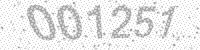

Question: What does the text say?
Ground Truth: 001251
Moondream: 001251


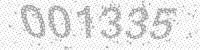

Question: What does the text say?
Ground Truth: 001335
Moondream: 001335


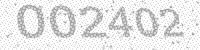

Question: What does the text say?
Ground Truth: 002402
Moondream: 002402
Accuracy: 80.50%


In [ ]:
moondream.eval()

correct = 0

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
    )

    if md_answer == sample['qa'][0]['answer']:
        correct += 1

    if i < 3:
        display(sample['image'])
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)

print(f"\n\nAccuracy: {correct / len(datasets['test']) * 100:.2f}%")